# Identify Pneumothorax Disease in Chest X-rays

A pneumothorax is an abnormal collection of air in the pleural space between the lung and the chest wall [2]. This air pushes on the outside of the lung making it collapse. A pneumothorax can be a complete lung collapse or a collapse of only a portion of the lung [3]. The symptoms of a pneumothorax typically include sudden onset of sharp, one-sided chest pain and shortness of breath. A pneumothorax can be caused by a blunt or penetrating chest injury, certain medical procedures and damage from underlying lung disease. It may also occur for no obvious reason [2][3]. In some occasions, a pneumothorax can be a life-threatening condition [3].

A pneumothorax is generally diagnosed using a chest X-ray [4]. However, they can sometimes be difficult to confirm from chest X-rays[1].

The aim of this project is to predict the existence of a pneumothorax in a test image using a convolutional neural network and indicate the extent of the condition using binary masks and encode them using run-length-encoded (RLE) masks.

In [1]:
# Importing the libraries to use.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pydicom
import os

from glob import glob
from collections import defaultdict
from tqdm import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Printing dataset directories.
dataset_path = "./dataset"
rles_path = "train-rle.csv"
print("The dataset folder has two directories:")
print(os.listdir(dataset_path))

# Import the training and test set
train_set = sorted(glob(dataset_path + '/dicom-images-train/*/*/*.dcm'))
test_set = sorted(glob(dataset_path + '/dicom-images-test/*/*/*.dcm'))
rles = pd.read_csv(rles_path)

# Printing the number of images in the training and testing sets
print("\nThe training set has %d images." %(len(train_set)))
print("The Testing set has %d images." %(len(test_set)))

# Importing RLEs

rles = pd.read_csv(rles_path)
rles.columns = ['ImageId', 'EncodedPixels']
print("\nRLES data:")
display(rles.head())

The dataset folder has two directories:
['dicom-images-test', 'dicom-images-train']

The training set has 10675 images.
The Testing set has 1372 images.

RLES data:


ImageId  \
0  1.2.276.0.7230010.3.1.4.8323329.5597.151787518...   
1  1.2.276.0.7230010.3.1.4.8323329.12515.15178752...   
2  1.2.276.0.7230010.3.1.4.8323329.4904.151787518...   
3  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   
4  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   

                                       EncodedPixels  
0                                                 -1  
1                                                 -1  
2   175349 7 1013 12 1009 17 1005 19 1003 20 1002...  
3   407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...  
4   252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...

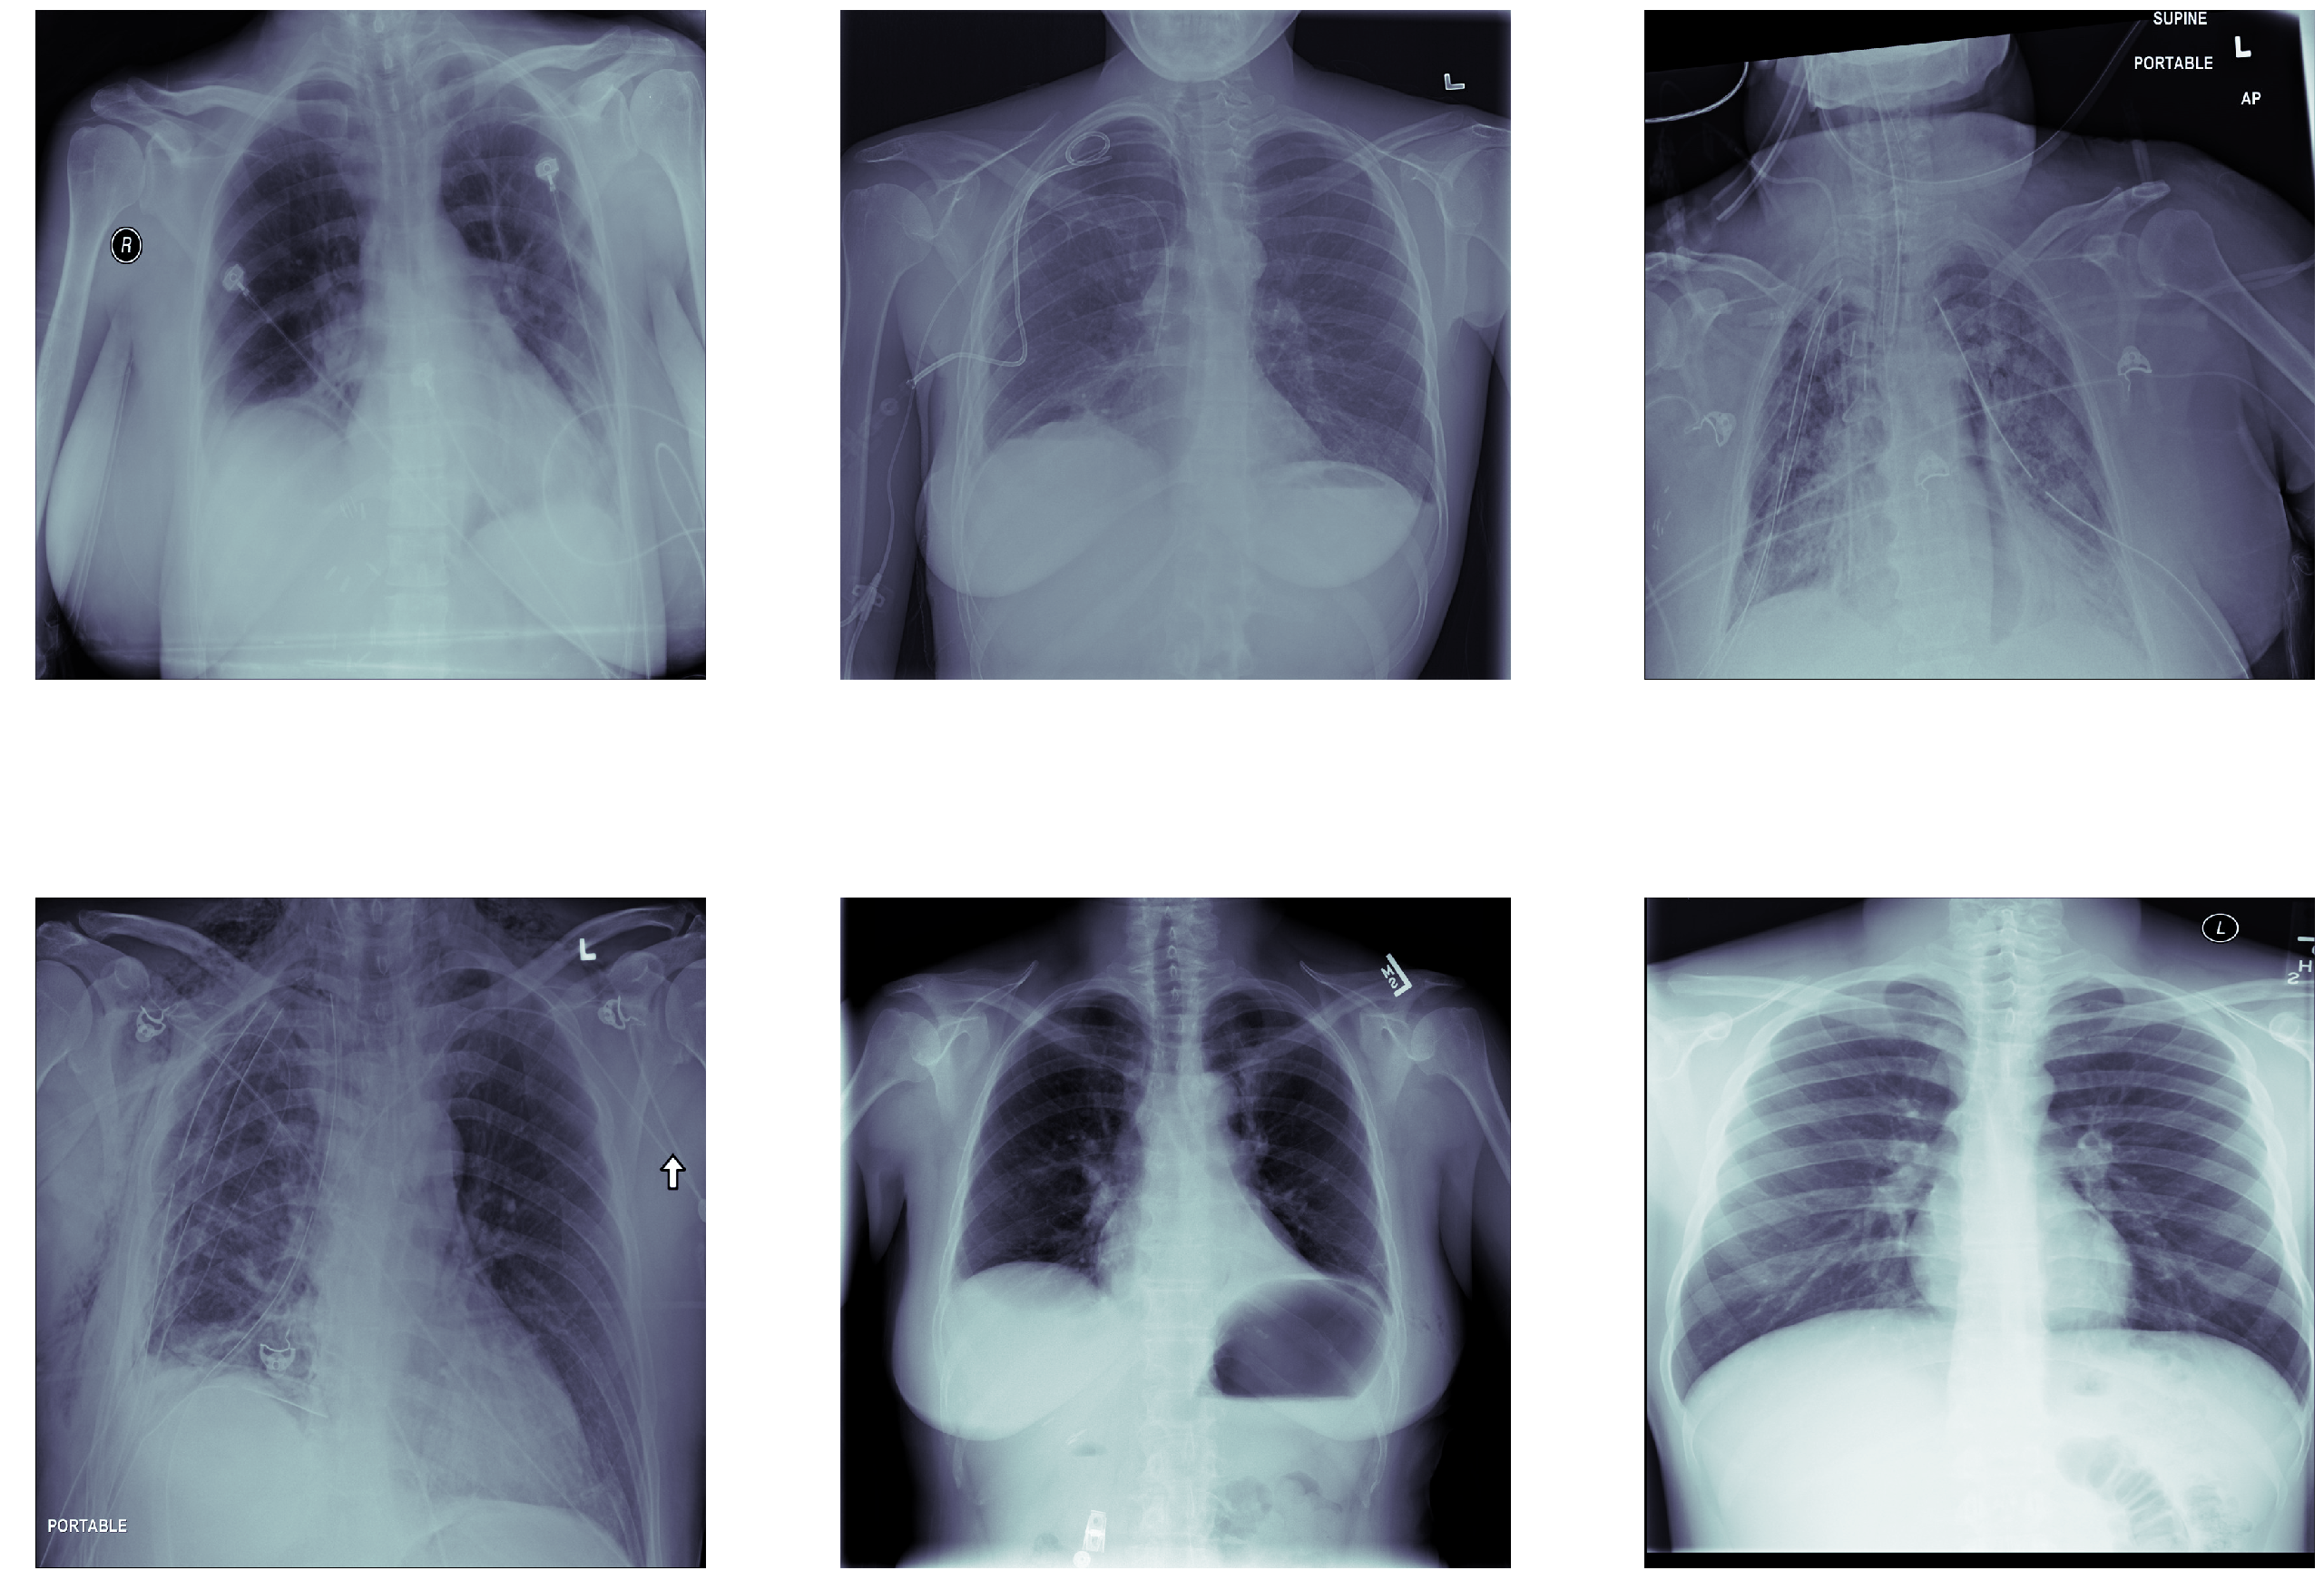

In [3]:
# Printing image samples

rows, columns = 2, 3
fig = plt.figure(figsize = (45, 33))

for i in range(1, 7):
    image_file = np.random.choice(test_set)
    img = pydicom.read_file(image_file).pixel_array
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='bone')
    plt.axis('off')
plt.show()

In [4]:
# Passing DICOM data and returning relevant fields

def dicom_dataset_to_dict(dicom_data, file_path, rles, encoded_pixels = True):
    dicom_dict = {}  
    
    # Parse fields with meaningful information
    dicom_dict['patient_name'] = dicom_data.PatientName
    dicom_dict['patient_id'] = dicom_data.PatientID
    dicom_dict['patient_age'] = int(dicom_data.PatientAge)
    dicom_dict['patient_sex'] = dicom_data.PatientSex
    dicom_dict['pixel_spacing'] = dicom_data.PixelSpacing
    dicom_dict['file_path'] = file_path
    dicom_dict['id'] = dicom_data.SOPInstanceUID
    
    # Check for annotaion in training set
    if encoded_pixels:
        encoded_pixels_list = rles[rles['ImageId'] == dicom_data.SOPInstanceUID]['EncodedPixels'].values       
        pneumothorax = False
        for encoded_pixels in encoded_pixels_list:
            if encoded_pixels != ' -1':
                pneumothorax = True
        
        # format the data
        dicom_dict['encoded_pixels_list'] = encoded_pixels_list
        dicom_dict['has_pneumothorax'] = pneumothorax
        dicom_dict['encoded_pixels_count'] = len(encoded_pixels_list)
        
    return dicom_dict

In [5]:
# Parse training data

train_data_df = pd.DataFrame()
train_data_list = []
for file_path in tqdm(train_set):
    dicom_data = pydicom.dcmread(file_path)
    train_data = dicom_dataset_to_dict(dicom_data, file_path, rles)
    train_data_list.append(train_data)
train_data_df = pd.DataFrame(train_data_list)

100%|██████████| 10675/10675 [00:44<00:00, 242.22it/s]


In [6]:
display(train_data_df.head())

encoded_pixels_count encoded_pixels_list  \
0                     1               [ -1]   
1                     1               [ -1]   
2                     1               [ -1]   
3                     1               [ -1]   
4                     1               [ -1]   

                                           file_path  has_pneumothorax  \
0  ./dataset/dicom-images-train/1.2.276.0.7230010...             False   
1  ./dataset/dicom-images-train/1.2.276.0.7230010...             False   
2  ./dataset/dicom-images-train/1.2.276.0.7230010...             False   
3  ./dataset/dicom-images-train/1.2.276.0.7230010...             False   
4  ./dataset/dicom-images-train/1.2.276.0.7230010...             False   

                                                  id  patient_age  \
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...           38   
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...           10   
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...           50   
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...           68   
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...           65   

                             patient_id                          patient_name  \
0  17d405a3-a0d2-4901-b33a-63906aa48d9f  17d405a3-a0d2-4901-b33a-63906aa48d9f   
1  8ab1ffda-8b65-4914-95d6-2e549e328666  8ab1ffda-8b65-4914-95d6-2e549e328666   
2  bfef51d3-6541-4792-bac1-d21d41ee60fd  bfef51d3-6541-4792-bac1-d21d41ee60fd   
3  d19d956f-4ddd-4688-81ff-909c85e0e2d9  d19d956f-4ddd-4688-81ff-909c85e0e2d9   
4  cf71a760-f693-4ccf-acd4-a41ff4845a5f  cf71a760-f693-4ccf-acd4-a41ff4845a5f   

  patient_sex   pixel_spacing  
0           M  [0.168, 0.168]  
1           F  [0.139, 0.139]  
2           F  [0.168, 0.168]  
3           F  [0.139, 0.139]  
4           M  [0.168, 0.168]

In [7]:
# Parse test data

test_data_df = pd.DataFrame()
test_data_list = []
for file_path in tqdm(test_set):
    dicom_data = pydicom.dcmread(file_path)
    test_data = dicom_dataset_to_dict(dicom_data, file_path, rles)
    test_data_list.append(test_data)
test_data_df = pd.DataFrame(test_data_list)

100%|██████████| 1372/1372 [00:05<00:00, 244.60it/s]


In [8]:
display(test_data_df.head(2))

encoded_pixels_count encoded_pixels_list  \
0                     0                  []   
1                     0                  []   

                                           file_path  has_pneumothorax  \
0  ./dataset/dicom-images-test/1.2.276.0.7230010....             False   
1  ./dataset/dicom-images-test/1.2.276.0.7230010....             False   

                                                  id  patient_age  \
0  1.2.276.0.7230010.3.1.4.8323329.5797.151787519...           81   
1  1.2.276.0.7230010.3.1.4.8323329.5798.151787519...           26   

                             patient_id                          patient_name  \
0  d6a76eb1-d814-46b1-a375-fcc796d2b0b0  d6a76eb1-d814-46b1-a375-fcc796d2b0b0   
1  ec2642f0-6721-4ceb-bce7-c3a124375a9c  ec2642f0-6721-4ceb-bce7-c3a124375a9c   

  patient_sex                               pixel_spacing  
0           M  [0.14300000000000002, 0.14300000000000002]  
1           M  [0.14300000000000002, 0.14300000000000002]

### Plotting the data

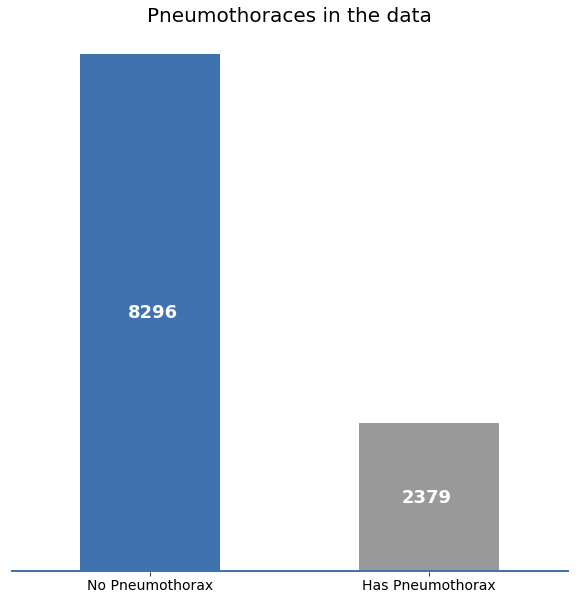

In [9]:
fig = plt.figure(figsize = (10,10 ))
data_ = train_data_df['has_pneumothorax'].value_counts().to_dict()
labels = ['No Pneumothorax', "Has Pneumothorax"]
data_ = pd.Series(dict(zip(labels, list(data_.values()))))

data_.plot.bar(color=('#3f72af', '#999999'))
plt.title("Pneumothoraces in the data", fontsize = 20)
#plt.xlabel("Pneumothorax", fontsize = 14)
#plt.ylabel("Total number", fontsize = 14)
plt.text(-.08, data_[0]/2, data_[0], fontsize = 18, va = 'center', color='white' , fontweight='bold')
plt.text(0.9, data_[1]/2, data_[1], fontsize = 18, va = 'center', color='white' , fontweight='bold')
plt.box(on=None)
plt.xticks(fontsize = 14,rotation='horizontal')
plt.yticks([])
#plt.ylim(0,)
plt.axhline(y = 0, linewidth=5, color='#3f72af')
plt.show()

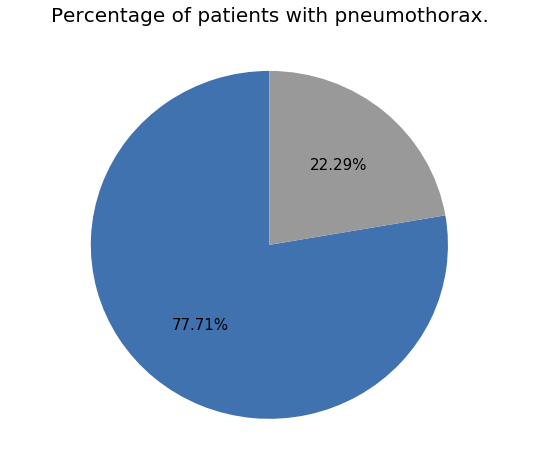

In [10]:
#Data to plot
train_data_to_plot = train_data_df['has_pneumothorax'].value_counts(sort = True)
labels = ('No Pneumothorax', "Has Pneumothorax")
colors = ('#3f72af', '#999999')
rcParams['figure.figsize'] = 8,8

#Plotting the data
patches, texts, autotexts = plt.pie(train_data_to_plot, labels = labels, colors = colors, 
                                    startangle = 90, autopct = '%1.2f%%', shadow = False)
plt.title('Percentage of patients with pneumothorax.', fontsize = 20)
for _ in texts: 
    _.set_fontsize(15)
    _.set_color('white')
for __ in autotexts: 
    __.set_fontsize(15)
plt.show()

About 22.29% of the dataset contains x-ray images with pneumothorax disease compared to 77.71% without the disease.

### Plotting pneumothorax by sex

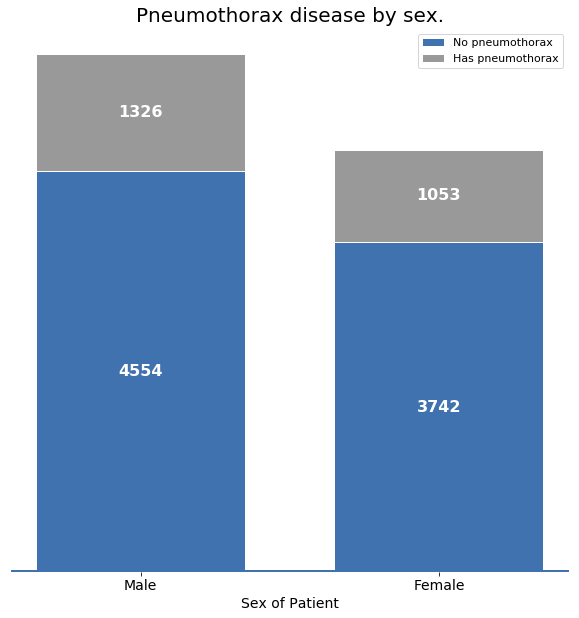

In [11]:
male_train = train_data_df[train_data_df['patient_sex'] == 'M']
female_train = train_data_df[train_data_df['patient_sex'] == 'F']

male_negative = len(male_train[male_train['has_pneumothorax'] == 0])
female_negative = len(female_train[female_train['has_pneumothorax'] == 0])
male_positive = len(male_train[male_train['has_pneumothorax'] == 1])
female_positive = len(female_train[female_train['has_pneumothorax'] == 1])

r = [0, 1]
barWidth = 0.7
x_labels = ["Male", "Female"]

bar1 = [male_negative, female_negative]
bar2 = [male_positive, female_positive]
bar_height = np.add(bar1, bar2).tolist()

fig = plt.figure(figsize = (10, 10))
b1 = plt.bar(r, bar1, color = '#3f72af', edgecolor = 'white', width = barWidth)
b2 = plt.bar(r, bar2, bottom = bar1, color = '#999999', edgecolor = 'white', width = barWidth)
plt.xticks(r, x_labels, fontsize = 14)
plt.yticks([])
plt.xlabel("Sex of Patient", fontsize = 14)
plt.legend(loc = 'upper right', labels = ['No pneumothorax', 'Has pneumothorax'], fontsize = 11)
plt.title('Pneumothorax disease by sex.', fontsize = 20)
plt.box(on = None)
plt.ylim(0,)
plt.axhline(y = 0, linewidth = 5, color = '#3f72af')

for a, b in zip(b1, b2):
    h1 = a.get_height()
    h2 = b.get_height()
    plt.text(a.get_x() + a.get_width() / 2, h1 / 2, h1, horizontalalignment="center", 
             verticalalignment = "center", color = "white", fontsize = 16, fontweight = "bold")
    plt.text(b.get_x() + b.get_width() / 2, h1 + h2 / 2, h2, verticalalignment = "center", 
             horizontalalignment = "center", color = "white", fontsize = 16, fontweight = "bold")

plt.show()

In [12]:
males_in_dataset = male_negative + male_positive
females_in_dataset = female_negative + female_positive
male_ratio = males_in_dataset/(males_in_dataset + females_in_dataset)
female_ratio = females_in_dataset/(males_in_dataset + females_in_dataset)
print('Ratio of males to females in the data set is %.2f to %.2f'% (male_ratio, female_ratio))

Ratio of males to females in the data set is 0.55 to 0.45


The dataset has more male xrays compared to female x-rays.

**Percentages**

In [13]:
print('Percentage of females with pneumothorax: %.2f' %round(female_positive/
                                                             (female_positive + female_negative), 2))
print('Percentage of females without pneumothorax: %.2f' %round(female_negative/
                                                                (female_positive + female_negative), 2))
print('Percentage of males with pneumothorax: %.2f' %round(male_positive/(male_positive + male_negative), 2))
print('Percentage of males without pneumothorax: %.2f' %round(male_negative/(male_positive + male_negative), 2))

Percentage of females with pneumothorax: 0.22
Percentage of females without pneumothorax: 0.78
Percentage of males with pneumothorax: 0.23
Percentage of males without pneumothorax: 0.77


The percentages of males and females with pneumothorax in the datatset seem to be roughly the same. This means that the sex of the patient isn't an indicator of the probability of a person having pneumothorax.

### Plotting pneumothorax by age

In [14]:
# Histogram of patients having pneumothorax and those that don't

# Splitting the data 
has_pneumothorax_train = train_data_df[train_data_df['has_pneumothorax'] == True]
no_pneumothorax_train = train_data_df[train_data_df['has_pneumothorax'] == False]

In [15]:
has_pneumothorax_train.head(3)

encoded_pixels_count                                encoded_pixels_list  \
6                      1  [ 209126 1 1019 6 1015 10 1012 13 1010 14 1008...   
13                     3  [ 891504 5 1018 8 1015 10 1013 12 1011 14 1009...   
14                     3  [ 261328 6 1015 11 1011 15 1007 18 1004 21 100...   

                                            file_path  has_pneumothorax  \
6   ./dataset/dicom-images-train/1.2.276.0.7230010...              True   
13  ./dataset/dicom-images-train/1.2.276.0.7230010...              True   
14  ./dataset/dicom-images-train/1.2.276.0.7230010...              True   

                                                   id  patient_age  \
6   1.2.276.0.7230010.3.1.4.8323329.10005.15178752...           53   
13  1.2.276.0.7230010.3.1.4.8323329.10011.15178752...           77   
14  1.2.276.0.7230010.3.1.4.8323329.10012.15178752...           74   

                              patient_id  \
6   bf8b1e5d-7ae8-4f5b-a387-8e0bb40733f1   
13  d3349d82-de72-443b-bd0e-00ac6177621f   
14  13ca140b-4e88-4f62-916d-e7a2bd2bde44   

                            patient_name patient_sex  \
6   bf8b1e5d-7ae8-4f5b-a387-8e0bb40733f1           F   
13  d3349d82-de72-443b-bd0e-00ac6177621f           M   
14  13ca140b-4e88-4f62-916d-e7a2bd2bde44           F   

                                 pixel_spacing  
6   [0.14300000000000002, 0.14300000000000002]  
13  [0.19431099999999998, 0.19431099999999998]  
14                              [0.168, 0.168]

In [16]:
no_pneumothorax_train.head(3)

encoded_pixels_count encoded_pixels_list  \
0                     1               [ -1]   
1                     1               [ -1]   
2                     1               [ -1]   

                                           file_path  has_pneumothorax  \
0  ./dataset/dicom-images-train/1.2.276.0.7230010...             False   
1  ./dataset/dicom-images-train/1.2.276.0.7230010...             False   
2  ./dataset/dicom-images-train/1.2.276.0.7230010...             False   

                                                  id  patient_age  \
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...           38   
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...           10   
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...           50   

                             patient_id                          patient_name  \
0  17d405a3-a0d2-4901-b33a-63906aa48d9f  17d405a3-a0d2-4901-b33a-63906aa48d9f   
1  8ab1ffda-8b65-4914-95d6-2e549e328666  8ab1ffda-8b65-4914-95d6-2e549e328666   
2  bfef51d3-6541-4792-bac1-d21d41ee60fd  bfef51d3-6541-4792-bac1-d21d41ee60fd   

  patient_sex   pixel_spacing  
0           M  [0.168, 0.168]  
1           F  [0.139, 0.139]  
2           F  [0.168, 0.168]

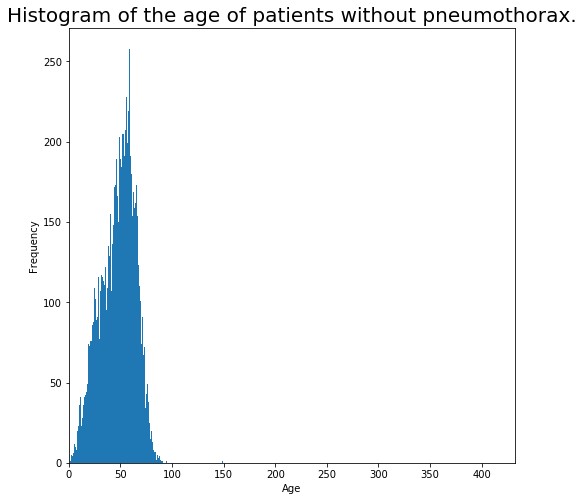

In [17]:
no_pneumothorax_train['patient_age'].plot.hist(bins = range(1,max(no_pneumothorax_train['patient_age']),1))
plt.xlim(0,)
plt.xlabel('Age')
plt.title('Histogram of the age of patients without pneumothorax.', fontsize = 20)
plt.show()

In [18]:
no_pneumo_age = no_pneumothorax_train['patient_age'].unique()
print('Unique ages:\n\n',no_pneumo_age)
print('\nMax age:',max(no_pneumo_age))

Unique ages:

 [ 38  10  50  68  65  45  55  26  63  37  14  54   9  66  40  70   5  64
  46  58  56  16  35  47  43  49  36  44  30  22  34  52  33  41  61  25
  42  31  72  57  51  39  60  71  15  12  75  77  28  53  13  19  24  48
  32  74  29  67  94  20  81  23  59  69  18  21  62  11  87   7  73  80
  78  79  27  76   8   4  83  17 413  85   6  82   2  86   3  84  90  89
  88   1 148]

Max age: 413


413 years is an outlier in the data.<br>
Ignoring the outlier and ploting the histogram again gives the following plot.

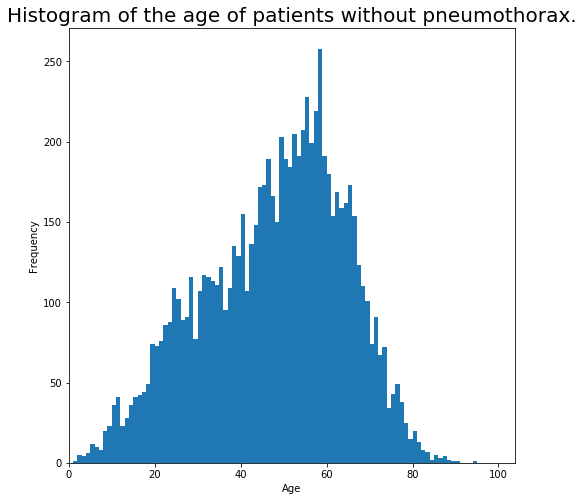

In [19]:
no_pneumothorax_train['patient_age'].plot.hist(bins = range(1,100,1))
plt.xlim(0,)
plt.xlabel('Age')
plt.title('Histogram of the age of patients without pneumothorax.', fontsize = 20)
plt.show()

The graph above shows that there people between the age of 45 years and 70 years don't have pnemothorax.

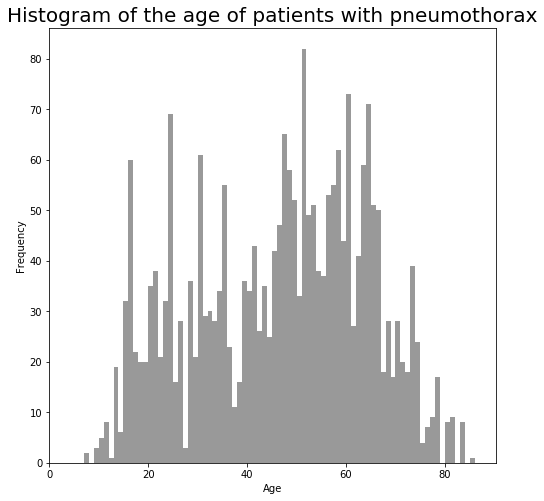

In [20]:
has_pneumothorax_train['patient_age'].plot.hist(bins = 
                                    range(1,max(has_pneumothorax_train['patient_age']),1), color = '#999999')
plt.xlim(0,)
plt.xlabel('Age')
plt.title('Histogram of the age of patients with pneumothorax', fontsize = 20)
plt.show()

There is no pattern for people with pneumothorax depending on age. This graph seems to show that pneumothorax can happen at any age.

### Extent of pneumothorax in the training data

In [21]:
# From https://www.kaggle.com/robertkag/rle-to-mask-converter

def rleToMask(rleString,pixel_spacing):
    height = pixel_spacing[0]
    width = pixel_spacing[1]
    rows,cols = height,width
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
        index -= 1
        img[index:index+length] = 255
        img = img.reshape(cols,rows)
    return img 

In [22]:
# Getting the affected area percentage

def infected_area (encoded_mask, pixel_spacing):
    total_pixels = 0
    
    for pixels,  in encoded_mask:
        decoded_mask = rleToMask(pixels, pixel_spacing).T
        total_pixels += np.count_nonzero(decoded_mask)
    area_per_pixel = pixel_spacing[0] * pixel_spacing[1]
    return area_per_pixel * total_pixels        

In [23]:
# Create a pneumothorax patients dataset subset
pneumothorax_df = train_data_df[train_data_df['has_pneumothorax']== 1].copy()
# get sum of non zero elements in mask
'''pneumothorax_df['pneumothorax_area'] = pneumothorax_df.apply(
    lambda row: infected_area(row['encoded_pixels_list'], row['pixel_spacing']),axis=1)'''

"pneumothorax_df['pneumothorax_area'] = pneumothorax_df.apply(\n    lambda row: infected_area(row['encoded_pixels_list'], row['pixel_spacing']),axis=1)"

In [24]:
pneumothorax_df.head(10)

encoded_pixels_count                                encoded_pixels_list  \
6                      1  [ 209126 1 1019 6 1015 10 1012 13 1010 14 1008...   
13                     3  [ 891504 5 1018 8 1015 10 1013 12 1011 14 1009...   
14                     3  [ 261328 6 1015 11 1011 15 1007 18 1004 21 100...   
18                     1  [ 592184 33 976 58 956 73 941 88 926 102 917 1...   
28                     1  [ 530522 1 1022 3 1019 6 1017 7 1016 9 1014 10...   
29                     1  [ 52111 20 1002 23 999 26 997 28 994 31 992 33...   
35                     1  [ 344194 1 1023 1 1023 2 1022 2 1021 3 1021 3 ...   
36                     1  [ 681160 2 1022 3 1022 3 1021 3 1021 4 1020 5 ...   
38                     2  [ 293539 1 1021 4 1018 7 1015 11 1010 15 1006 ...   
41                     1  [ 569678 1 1023 2 1022 3 1021 5 1020 5 1020 6 ...   

                                            file_path  has_pneumothorax  \
6   ./dataset/dicom-images-train/1.2.276.0.7230010...              True   
13  ./dataset/dicom-images-train/1.2.276.0.7230010...              True   
14  ./dataset/dicom-images-train/1.2.276.0.7230010...              True   
18  ./dataset/dicom-images-train/1.2.276.0.7230010...              True   
28  ./dataset/dicom-images-train/1.2.276.0.7230010...              True   
29  ./dataset/dicom-images-train/1.2.276.0.7230010...              True   
35  ./dataset/dicom-images-train/1.2.276.0.7230010...              True   
36  ./dataset/dicom-images-train/1.2.276.0.7230010...              True   
38  ./dataset/dicom-images-train/1.2.276.0.7230010...              True   
41  ./dataset/dicom-images-train/1.2.276.0.7230010...              True   

                                                   id  patient_age  \
6   1.2.276.0.7230010.3.1.4.8323329.10005.15178752...           53   
13  1.2.276.0.7230010.3.1.4.8323329.10011.15178752...           77   
14  1.2.276.0.7230010.3.1.4.8323329.10012.15178752...           74   
18  1.2.276.0.7230010.3.1.4.8323329.10016.15178752...           57   
28  1.2.276.0.7230010.3.1.4.8323329.10025.15178752...           30   
29  1.2.276.0.7230010.3.1.4.8323329.10026.15178752...           52   
35  1.2.276.0.7230010.3.1.4.8323329.10031.15178752...           49   
36  1.2.276.0.7230010.3.1.4.8323329.10032.15178752...           38   
38  1.2.276.0.7230010.3.1.4.8323329.10034.15178752...           51   
41  1.2.276.0.7230010.3.1.4.8323329.10037.15178752...           58   

                              patient_id  \
6   bf8b1e5d-7ae8-4f5b-a387-8e0bb40733f1   
13  d3349d82-de72-443b-bd0e-00ac6177621f   
14  13ca140b-4e88-4f62-916d-e7a2bd2bde44   
18  c844072c-3ba6-48d2-b009-4eb329fecd26   
28  78052684-2b69-4fde-a4bf-18aeb9a9e644   
29  43f9fcb6-ef69-4c8c-afa2-181c39898e5d   
35  31f5c752-aaf7-481b-9486-5caa145f9eee   
36  7c0c842c-0589-4c0a-a5a3-100d2a9c1864   
38  7c65ad44-d6a4-413c-a9f8-b8d183dfcc9d   
41  1e0238d0-faca-4d50-ba75-5a5e2f0e55df   

                            patient_name patient_sex  \
6   bf8b1e5d-7ae8-4f5b-a387-8e0bb40733f1           F   
13  d3349d82-de72-443b-bd0e-00ac6177621f           M   
14  13ca140b-4e88-4f62-916d-e7a2bd2bde44           F   
18  c844072c-3ba6-48d2-b009-4eb329fecd26           F   
28  78052684-2b69-4fde-a4bf-18aeb9a9e644           F   
29  43f9fcb6-ef69-4c8c-afa2-181c39898e5d           M   
35  31f5c752-aaf7-481b-9486-5caa145f9eee           M   
36  7c0c842c-0589-4c0a-a5a3-100d2a9c1864           M   
38  7c65ad44-d6a4-413c-a9f8-b8d183dfcc9d           M   
41  1e0238d0-faca-4d50-ba75-5a5e2f0e55df           F   

                                 pixel_spacing  
6   [0.14300000000000002, 0.14300000000000002]  
13  [0.19431099999999998, 0.19431099999999998]  
14                              [0.168, 0.168]  
18                              [0.139, 0.139]  
28  [0.19431099999999998, 0.19431099999999998]  
29                              [0.139, 0.139]  
35  [0.14300000000000002, 0.14300000000000002]  
36                              [0.171, 0.1

### References

- [DICOM Processing and Segmentation in Python](https://www.raddq.com/dicom-processing-segmentation-visualization-in-python)
- [Getting to know DICOM and the data](https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data/data)
- [Mask-rcnn with augmentation and multiple masks](https://www.kaggle.com/abhishek/mask-rcnn-with-augmentation-and-multiple-masks#Convert-Model-to-Evaluation-Mode)
- [Intro - chest xray, DICOM, viz, U-nets - full data](https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data)
- [Full dataset](https://www.kaggle.com/seesee/full-dataset)
- [Finding Pneumo part 1 EDA and UNET](https://www.kaggle.com/ekhtiar/finding-pneumo-part-1-eda-and-unet)
- [Read DICOM and ploting using matplotlib](https://pydicom.github.io/pydicom/stable/auto_examples/input_output/plot_read_dicom.html)
- [Converting a dicom dataset to a standard python dictionary](https://github.com/pydicom/pydicom/issues/319)
- [Image Pre-processing for Chest X-ray](https://www.kaggle.com/seriousran/image-pre-processing-for-chest-x-ray)
- [RLE to mask converter](https://www.kaggle.com/robertkag/rle-to-mask-converter)